### **PREDICCIÓN DE CONVERSIÓN EN CAMPAÑAS DE MARKETING DIGITAL CON MACHINE LEARNING**

### **Análisis campaña de "Retention"**

### **INSTALL**

In [1]:
#!pip install imbalanced-learn
#!pip install shap

### **IMPORTS**

In [2]:
# === Librerías estándar ===
import re  # Trabajo con expresiones regulares
import math  # Funciones matemáticas
import warnings  # Manejo de advertencias

# === Manipulación y análisis de datos ===
import pandas as pd  # Manejo y análisis de datos estructurados
import numpy as np  # Operaciones numéricas y manejo de arrays

# === Visualización ===
import matplotlib.pyplot as plt  # Creación de gráficos básicos
from mpl_toolkits.mplot3d import Axes3D  # Gráficos 3D
import seaborn as sns  # Gráficos estadísticos y estilos
sns.set_style('whitegrid')  # Estilo de gráficos para seaborn

# === Selección de modelos y preprocesamiento ===
from sklearn.model_selection import (
    train_test_split,  # División de datos en conjuntos de entrenamiento y prueba
    GridSearchCV,  # Búsqueda de hiperparámetros con validación cruzada
    StratifiedKFold,  # Validación cruzada estratificada
    RandomizedSearchCV  # Búsqueda de hiperparámetros aleatoria
)
from sklearn.preprocessing import (
    StandardScaler,  # Escalado de características
    LabelEncoder  # Codificación de etiquetas categóricas
)
from sklearn.pipeline import Pipeline  # Construcción de pipelines para preprocesamiento y modelado

# === Manejo de desbalanceo de clases ===
from imblearn.combine import SMOTETomek  # SMOTE + Tomek Links para balanceo de datos
from imblearn.over_sampling import SMOTE  # SMOTE para sobremuestreo

# === Modelos de Machine Learning ===
from sklearn.ensemble import (
    RandomForestClassifier,  # Clasificador Random Forest
    GradientBoostingClassifier,  # Clasificador Gradient Boosting
    StackingClassifier,  # Clasificador basado en apilamiento
    RandomForestRegressor,  # Regresor Random Forest
    GradientBoostingRegressor  # Regresor Gradient Boosting
)
from xgboost import XGBClassifier, XGBRegressor  # Clasificador y regresor XGBoost

# === Métricas y evaluación ===
from sklearn.metrics import (
    classification_report,  # Reporte de métricas para clasificación
    confusion_matrix,  # Matriz de confusión
    ConfusionMatrixDisplay,  # Visualización de matriz de confusión
    roc_auc_score,  # Métrica AUC-ROC
    roc_curve,  # Curva ROC
    f1_score,  # F1-Score
    recall_score,  # Recall (Sensibilidad)
    precision_score,  # Precisión
    mean_absolute_error,  # MAE (Error absoluto medio) para regresión
    mean_squared_error  # MSE (Error cuadrático medio) para regresión
)

# === Clustering ===
from sklearn.cluster import KMeans  # Algoritmo de clustering K-Means
from sklearn.metrics import (
    silhouette_samples,  # Evaluación de silueta para cada punto
    silhouette_score  # Puntuación general de silueta para el modelo
)

# === Reducción de dimensionalidad ===
from sklearn.decomposition import PCA  # Análisis de componentes principales (PCA)

# === Utilidades ===
from sklearn.utils.class_weight import compute_class_weight  # Cálculo de pesos para clases desbalanceadas
import joblib  # Guardar y cargar modelos entrenados

### **CONFIGURACIONES**

In [3]:
# Mostrar todas las columnas de un DataFrame
pd.set_option('display.max_columns', None)

# Ignorar FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### **CARGA DE DATOS Y PRIMERAS EXPLORACIONES**

In [4]:
# Cargar los datos
df = pd.read_csv('data/digital_marketing_campaign_dataset.csv')

In [5]:
# Filtrar el DataFrame para obtener solo las filas donde CampaignType es "Awareness"
df = df[df['CampaignType'] == 'Retention']

In [ ]:
df.head(100)

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1
8,8008,36,Female,140788,Email,Retention,9421.250951,0.023536,0.112585,13,5.472843,14.287421,73,4,8,5,460,IsConfid,ToolConfid,1
10,8010,28,Male,88319,PPC,Retention,7283.887364,0.269148,0.109868,47,2.054181,3.294720,94,16,5,6,1987,IsConfid,ToolConfid,1
27,8027,39,Male,98311,Social Media,Retention,6920.238875,0.010644,0.105648,39,2.521653,9.332746,98,17,6,1,2688,IsConfid,ToolConfid,1
28,8028,61,Female,27549,Referral,Retention,6250.274939,0.154715,0.079767,25,3.952742,10.672945,92,17,1,3,68,IsConfid,ToolConfid,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,8391,38,Male,23436,Referral,Retention,1131.362918,0.209128,0.178064,39,2.714786,1.906094,73,13,9,7,1889,IsConfid,ToolConfid,1
392,8392,49,Male,113550,SEO,Retention,1442.604524,0.134576,0.159426,47,2.415097,10.700966,28,11,6,7,2192,IsConfid,ToolConfid,1
403,8403,41,Male,28906,PPC,Retention,3520.524715,0.111165,0.055067,33,2.466179,14.798148,46,14,4,7,450,IsConfid,ToolConfid,1
407,8407,39,Female,92855,Email,Retention,3671.216947,0.235906,0.035111,11,9.070539,7.021473,90,7,7,9,1428,IsConfid,ToolConfid,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1947 entries, 1 to 7996
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           1947 non-null   int64  
 1   Age                  1947 non-null   int64  
 2   Gender               1947 non-null   object 
 3   Income               1947 non-null   int64  
 4   CampaignChannel      1947 non-null   object 
 5   CampaignType         1947 non-null   object 
 6   AdSpend              1947 non-null   float64
 7   ClickThroughRate     1947 non-null   float64
 8   ConversionRate       1947 non-null   float64
 9   WebsiteVisits        1947 non-null   int64  
 10  PagesPerVisit        1947 non-null   float64
 11  TimeOnSite           1947 non-null   float64
 12  SocialShares         1947 non-null   int64  
 13  EmailOpens           1947 non-null   int64  
 14  EmailClicks          1947 non-null   int64  
 15  PreviousPurchases    1947 non-null   int64 

In [8]:
df.describe()

,CustomerID,Age,Income,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
count,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000
mean,12013.594761,44.081664,84799.631228,5017.135162,0.156076,0.103210,24.581921,5.478963,7.687385,49.422702,9.589625,4.421161,4.483821,2468.614278,0.858243
std,2285.731374,14.665226,37731.600254,2807.118951,0.085108,0.054519,14.255770,2.588867,4.209951,29.058391,5.789876,2.823758,2.867782,1410.494515,0.348890
min,8001.000000,18.000000,20154.000000,110.168672,0.010376,0.010020,0.000000,1.000428,0.502116,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,10046.500000,32.000000,51530.000000,2658.707316,0.081344,0.056149,13.000000,3.243816,3.974272,24.000000,5.000000,2.000000,2.000000,1278.000000,1.000000
50%,12004.000000,44.000000,84913.000000,5029.948425,0.157007,0.103085,24.000000,5.369791,7.643555,48.000000,10.000000,4.000000,4.000000,2462.000000,1.000000
75%,13980.500000,56.000000,116916.000000,7417.642827,0.230288,0.149547,37.000000,7.784057,11.506979,75.000000,15.000000,7.000000,7.000000,3645.500000,1.000000
max,15996.000000,69.000000,149883.000000,9981.703692,0.299488,0.199675,49.000000,9.999055,14.979306,99.000000,19.000000,9.000000,9.000000,4999.000000,1.000000


In [9]:
# Iterar por cada columna y obtener los valores únicos
unique_values = {col: df[col].unique() for col in df.columns}

# Mostrar los valores únicos de cada columna
for column, values in unique_values.items():
    print(f"Columna: {column}")
    print(f"Valores únicos: {values}")
    print("-" * 50)

Columna: CustomerID
Valores únicos: [ 8001  8008  8010 ... 15992 15993 15996]
--------------------------------------------------
Columna: Age
Valores únicos: [69 36 28 39 61 68 24 56 42 43 64 31 34 67 46 32 41 58 18 52 29 30 49 47
 19 59 62 20 54 50 66 22 26 45 25 33 21 63 65 48 38 57 53 27 37 23 55 51
 35 44 40 60]
--------------------------------------------------
Columna: Gender
Valores únicos: ['Male' 'Female']
--------------------------------------------------
Columna: Income
Valores únicos: [ 41760 140788  88319 ... 138422 120271  44718]
--------------------------------------------------
Columna: CampaignChannel
Valores únicos: ['Email' 'PPC' 'Social Media' 'Referral' 'SEO']
--------------------------------------------------
Columna: CampaignType
Valores únicos: ['Retention']
--------------------------------------------------
Columna: AdSpend
Valores únicos: [3898.66860568 9421.25095054 7283.88736398 ... 2024.14884755 6973.12017389
 1424.61344619]
--------------------------------

In [10]:
df.nunique()

CustomerID             1947
Age                      52
Gender                    2
Income                 1940
CampaignChannel           5
CampaignType              1
AdSpend                1947
ClickThroughRate       1947
ConversionRate         1947
WebsiteVisits            50
PagesPerVisit          1947
TimeOnSite             1947
SocialShares            100
EmailOpens               20
EmailClicks              10
PreviousPurchases        10
LoyaltyPoints          1597
AdvertisingPlatform       1
AdvertisingTool           1
Conversion                2
dtype: int64

In [11]:
# Iterar por cada columna y mostrar los value_counts
for col in df.columns:
    print(f"Columna: {col}")
    print(df[col].value_counts())
    print("-" * 50)

Columna: CustomerID
CustomerID
15996    1
8001     1
8008     1
8010     1
8027     1
        ..
8073     1
8066     1
8064     1
8063     1
8061     1
Name: count, Length: 1947, dtype: int64
--------------------------------------------------
Columna: Age
Age
68    52
49    51
30    50
56    48
34    48
50    47
64    46
46    45
45    45
39    45
32    44
47    44
43    43
52    43
38    41
63    39
60    39
42    39
66    38
65    38
37    38
27    37
26    37
51    37
62    37
19    37
61    36
36    36
35    35
55    35
31    35
41    35
58    35
54    34
25    34
33    34
24    33
23    33
40    33
69    32
53    32
21    31
28    31
22    31
57    30
18    30
29    30
59    30
48    30
67    29
44    29
20    26
Name: count, dtype: int64
--------------------------------------------------
Columna: Gender
Gender
Female    1165
Male       782
Name: count, dtype: int64
--------------------------------------------------
Columna: Income
Income
93185     2
131682    2
28039     2
60888 

### **LIMPIEZA DE DATOS**

In [12]:
# Eliminar columnas irrelevantes
df = df.drop(columns=['AdvertisingPlatform', 'AdvertisingTool'])

### **EDA**

C:\Users\mikel\AppData\Local\Temp\ipykernel_27492\3551082037.py:31: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax, palette=palette)
C:\Users\mikel\AppData\Local\Temp\ipykernel_27492\3551082037.py:31: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax, palette=palette)
C:\Users\mikel\AppData\Local\Temp\ipykernel_27492\3551082037.py:31: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax, palette=palette)


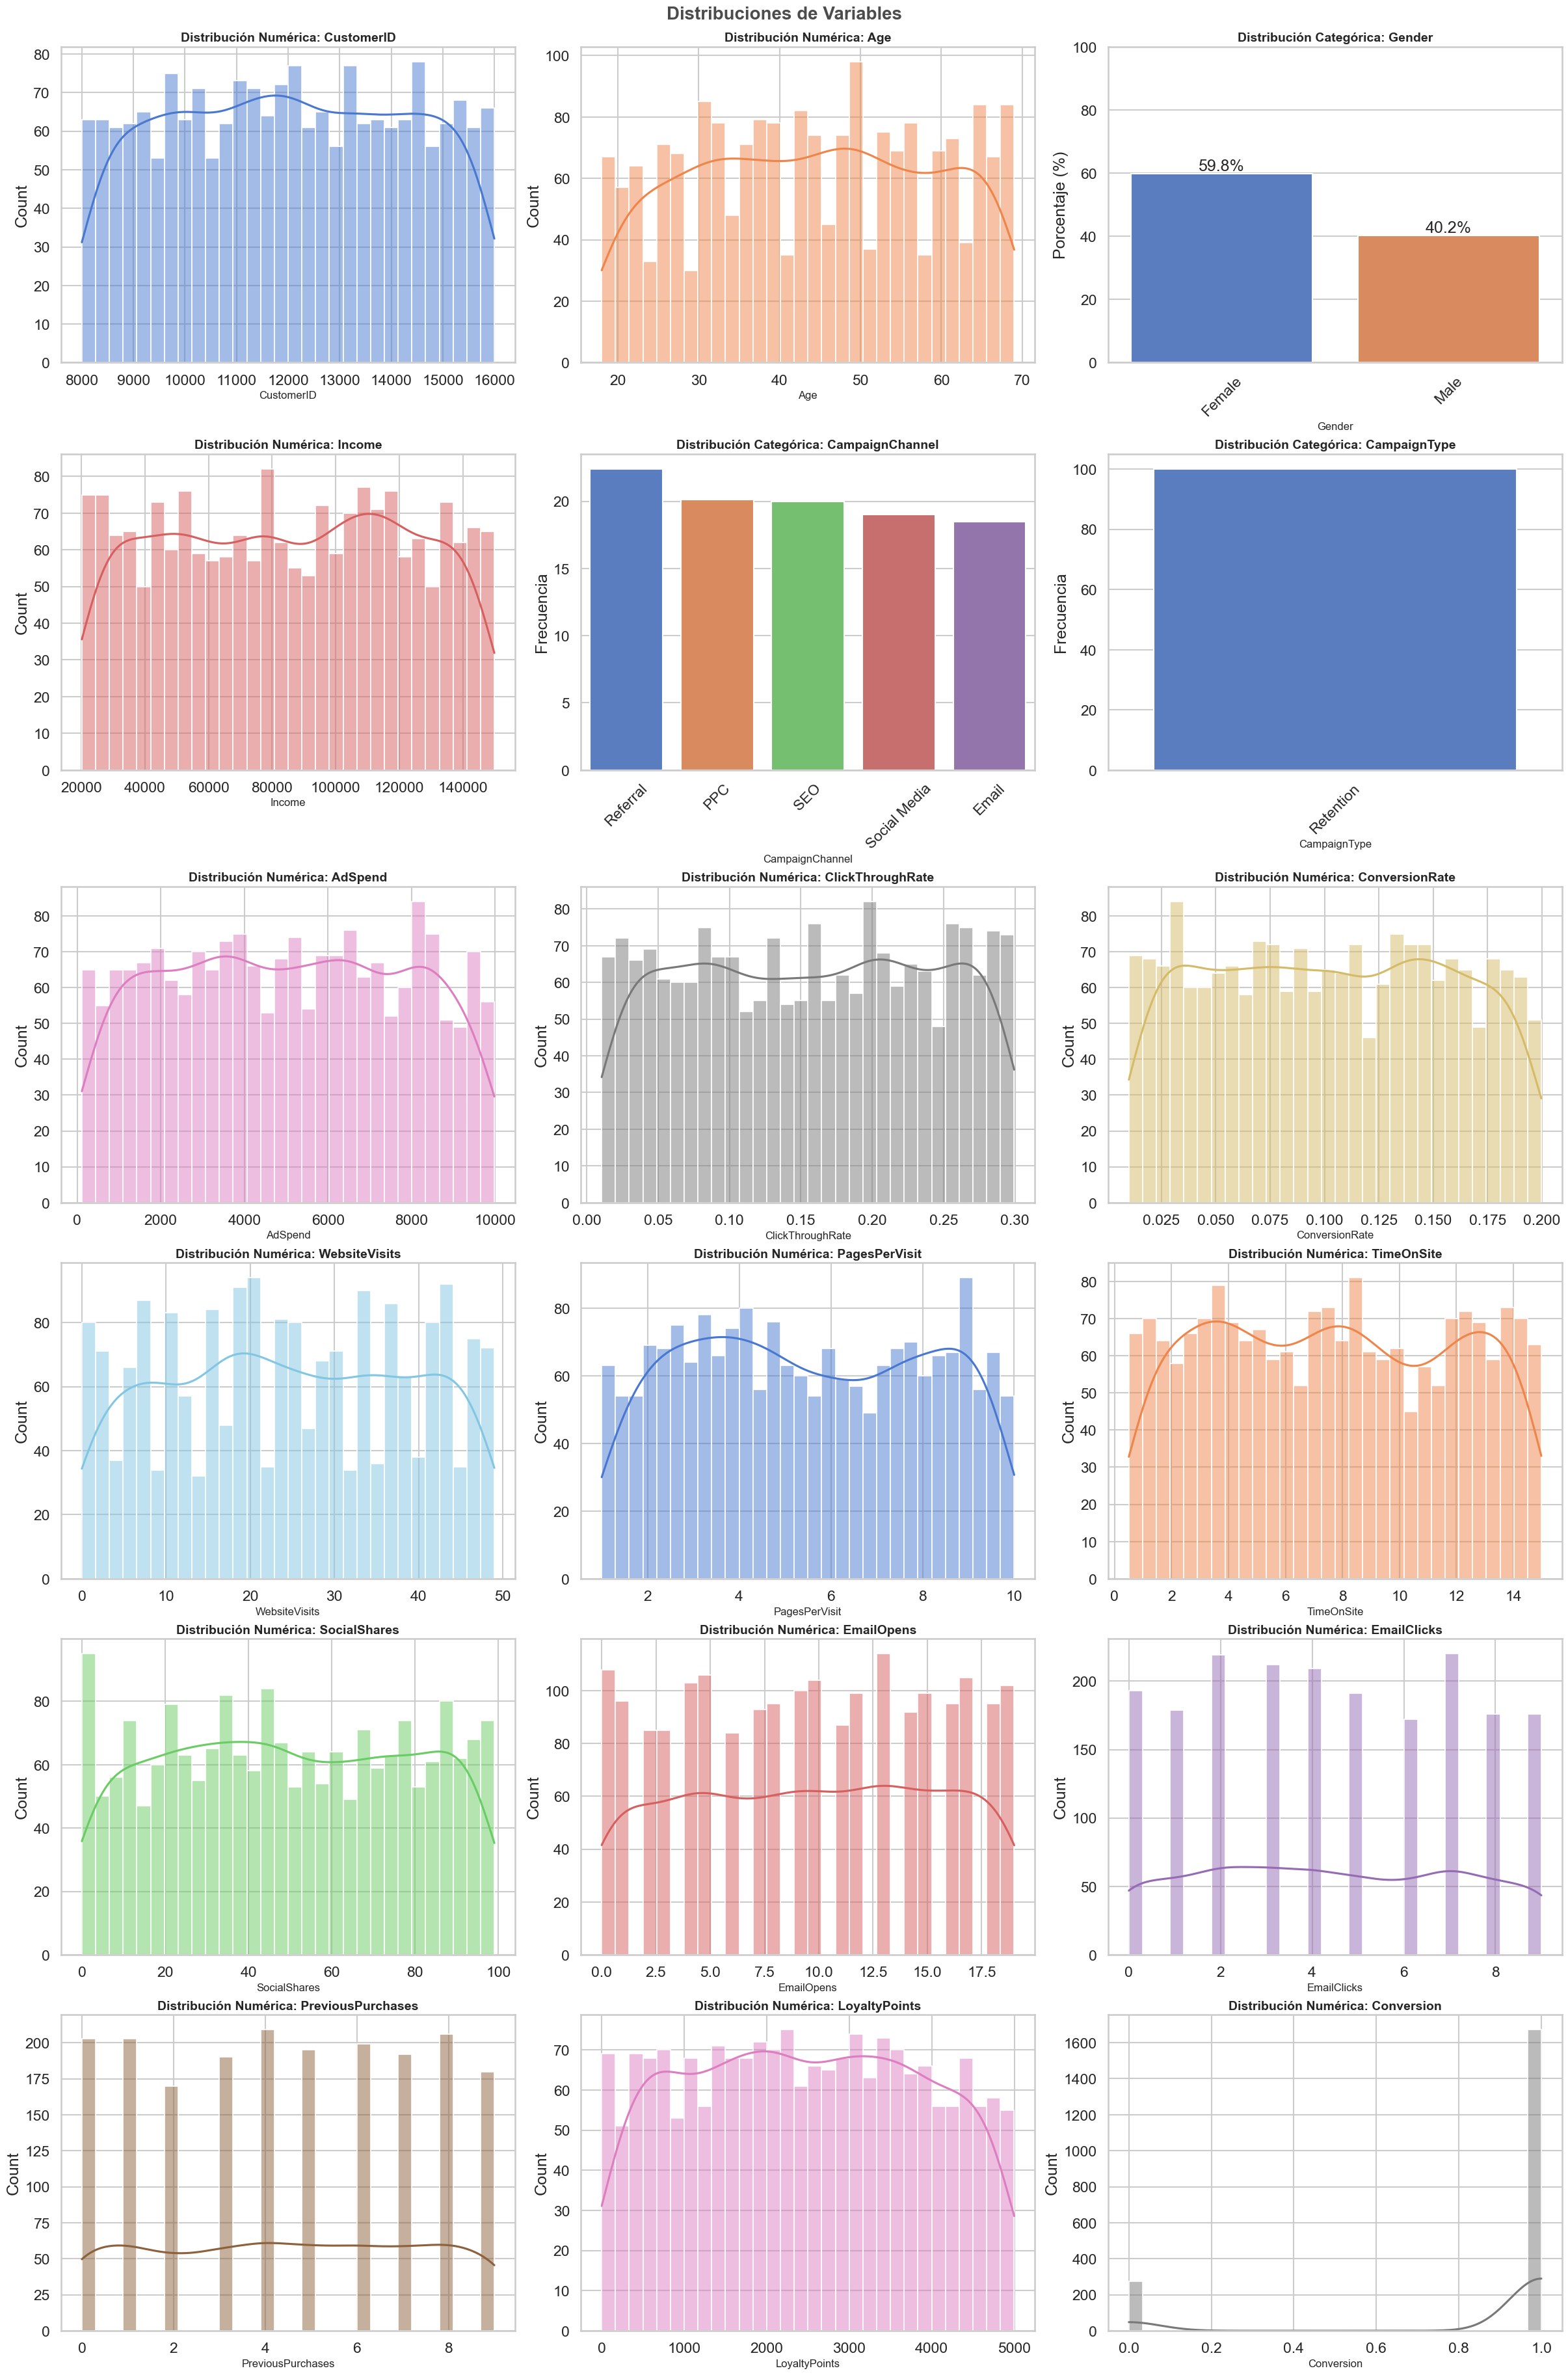

In [13]:
# Configuración general
sns.set_theme(style="whitegrid")
sns.set_context("talk")

# Número de columnas por fila
columns_per_row = 3

# Número total de columnas
total_columns = len(df.columns)

# Número de filas necesarias
rows = math.ceil(total_columns / columns_per_row)

# Crear subplots
fig, axes = plt.subplots(rows, columns_per_row, figsize=(24, rows * 6), constrained_layout=True)
axes = axes.flatten()

# Colores personalizados
palette = sns.color_palette("muted")

# Visualizar cada columna
for i, column in enumerate(df.columns):
    ax = axes[i]
    if df[column].dtype in ['int64', 'float64']:
        # Variables numéricas
        sns.histplot(df[column], kde=True, bins=30, ax=ax, color=palette[i % len(palette)])
        ax.set_title(f'Distribución Numérica: {column}', fontsize=14, fontweight='bold')
    elif df[column].dtype == 'object' or df[column].dtype == 'bool':
        # Variables categóricas
        value_counts = df[column].value_counts(normalize=True) * 100  # Porcentajes
        sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax, palette=palette)
        ax.set_title(f'Distribución Categórica: {column}', fontsize=14, fontweight='bold')
        ax.set_ylabel('Porcentaje (%)' if column == "Gender" else 'Frecuencia')
        ax.set_ylim(0, 100 if column == "Gender" else None)
        
        # Agregar etiquetas de porcentaje solo para 'Gender'
        if column == "Gender":
            for container in ax.containers:
                ax.bar_label(container, fmt='%.1f%%')
        
        ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel(column, fontsize=12)

# Ajustar los ejes vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Título general
fig.suptitle('Distribuciones de Variables', fontsize=20, fontweight='bold', color="#4c4c4c", y=1.01)

plt.show()

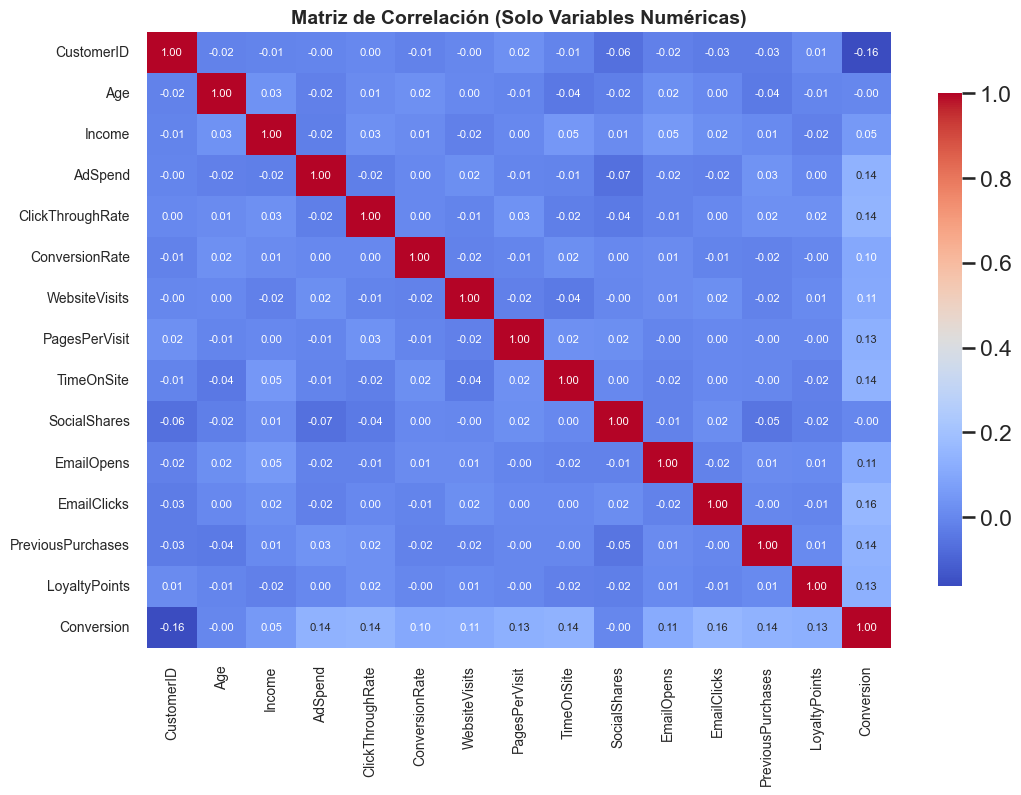

In [14]:
# Seleccionar solo columnas numéricas
numerical_df = df.select_dtypes(include=['int64', 'float64'])

# Calcular la matriz de correlación
correlation_matrix = numerical_df.corr()

# Mapa de calor con texto y números más pequeños
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    annot_kws={"size": 8},  # Tamaño del texto en los números
    cbar_kws={"shrink": 0.8}  # Reducir la barra de color
)
plt.title('Matriz de Correlación (Solo Variables Numéricas)', fontsize=14, weight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

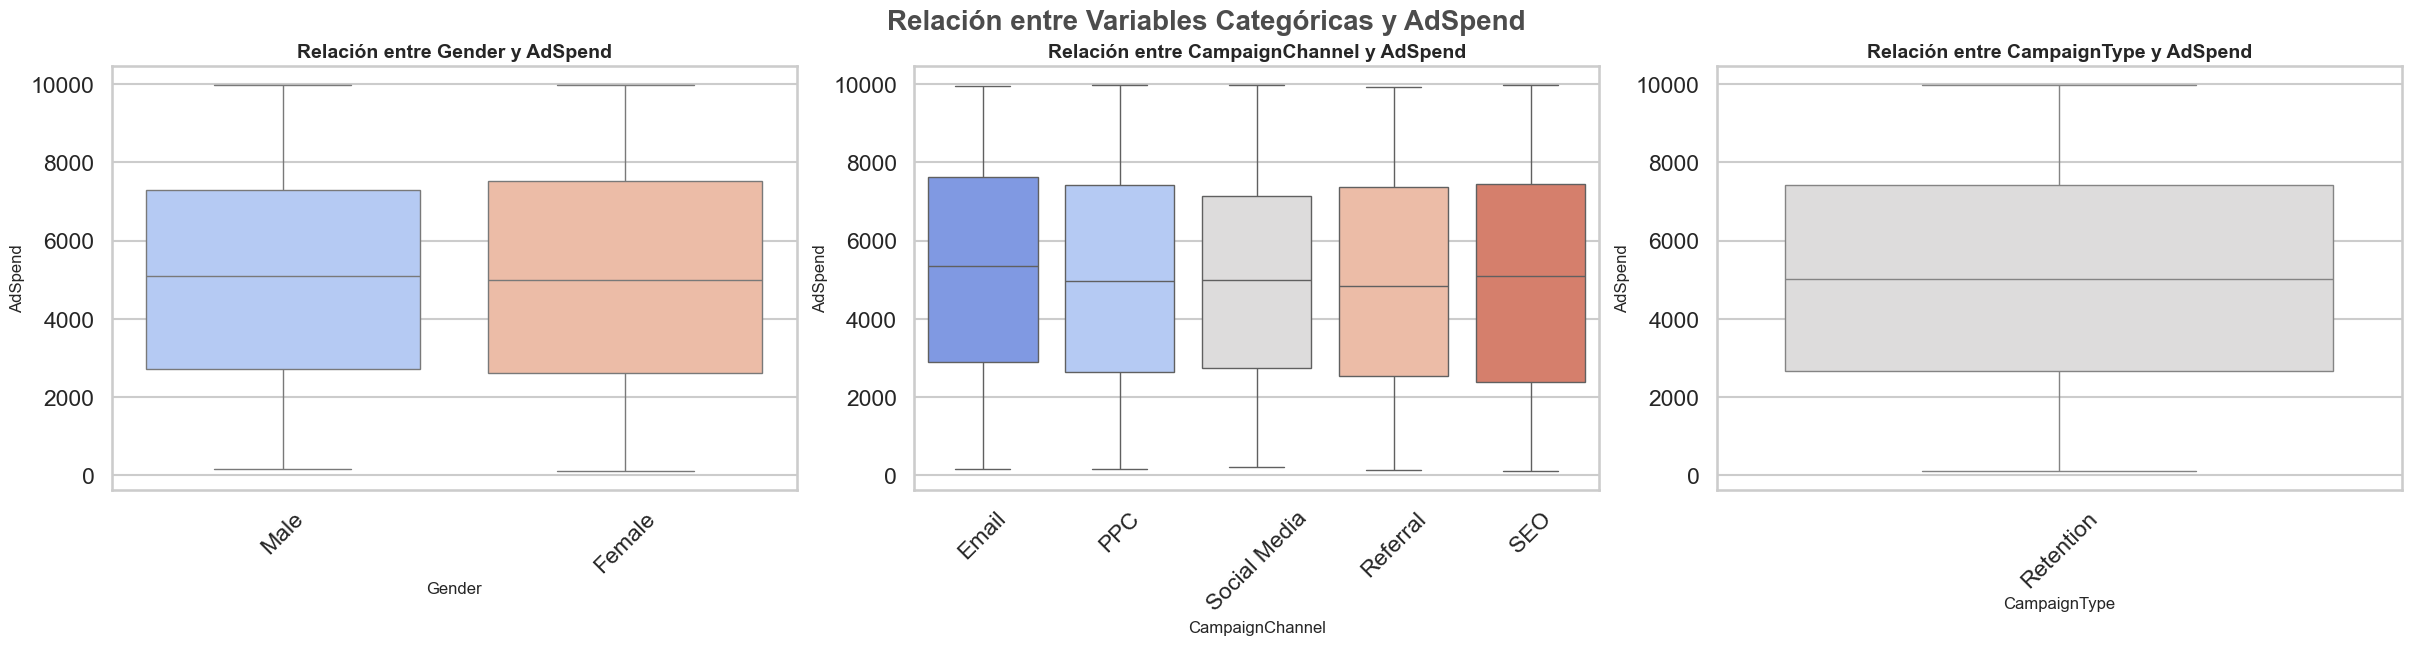

In [15]:
# Variables categóricas a explorar
categorical_vars = ['Gender', 'CampaignChannel', 'CampaignType']

# Variable numérica a analizar
numeric_var = 'AdSpend'

# Número de gráficos por fila
columns_per_row = 3

# Número total de variables categóricas
total_variables = len(categorical_vars)

# Número de filas necesarias
rows = math.ceil(total_variables / columns_per_row)

# Crear subplots
fig, axes = plt.subplots(rows, columns_per_row, figsize=(24, rows * 6), constrained_layout=True)
axes = axes.flatten()

# Generar boxplots
for i, cat_var in enumerate(categorical_vars):
    sns.boxplot(data=df, x=cat_var, y=numeric_var, ax=axes[i], palette='coolwarm')
    axes[i].set_title(f'Relación entre {cat_var} y {numeric_var}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(cat_var, fontsize=12)
    axes[i].set_ylabel(numeric_var, fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# Eliminar ejes vacíos si los hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Título general
fig.suptitle('Relación entre Variables Categóricas y AdSpend', fontsize=20, fontweight='bold', color='#4c4c4c', y=1.05)

plt.show()

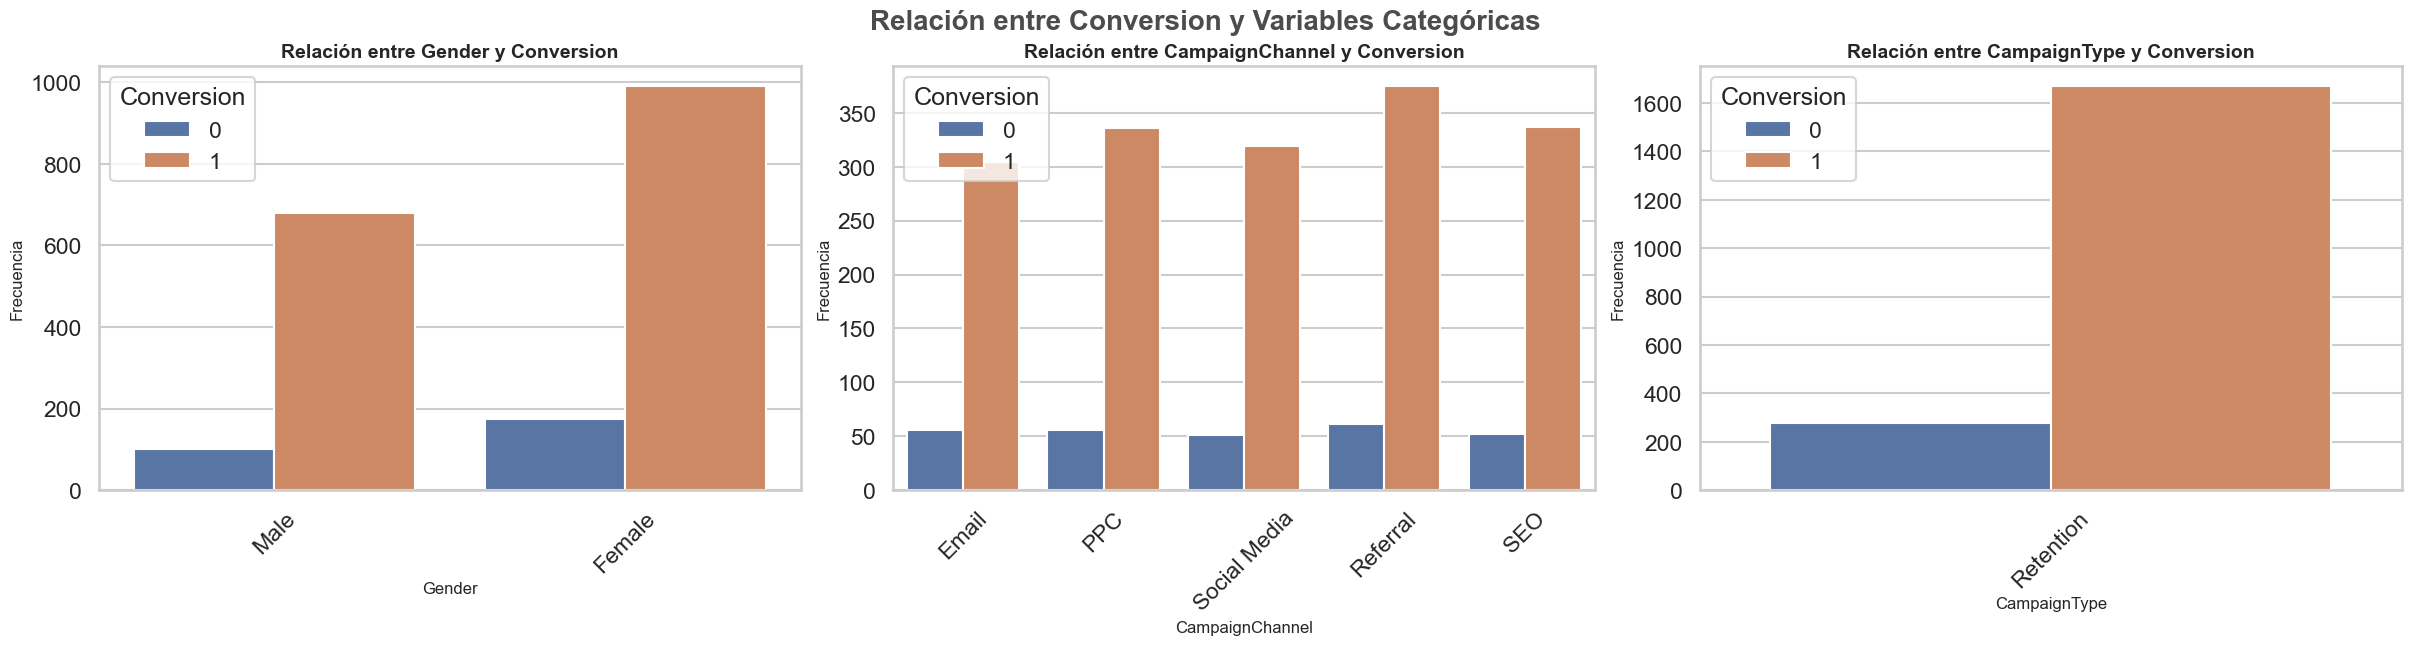

In [16]:
# Variables categóricas a explorar
categorical_vars = ['Gender', 'CampaignChannel', 'CampaignType']

# Número de gráficos por fila
columns_per_row = 3

# Número total de variables categóricas
total_variables = len(categorical_vars)

# Número de filas necesarias
rows = math.ceil(total_variables / columns_per_row)

# Crear subplots
fig, axes = plt.subplots(rows, columns_per_row, figsize=(24, rows * 6), constrained_layout=True)
axes = axes.flatten()

# Generar countplots
for i, cat_var in enumerate(categorical_vars):
    sns.countplot(data=df, x=cat_var, hue='Conversion', ax=axes[i])
    axes[i].set_title(f'Relación entre {cat_var} y Conversion', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(cat_var, fontsize=12)
    axes[i].set_ylabel('Frecuencia', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# Eliminar ejes vacíos si los hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Título general
fig.suptitle('Relación entre Conversion y Variables Categóricas', fontsize=20, fontweight='bold', color='#4c4c4c', y=1.05)

plt.show()

In [17]:
# Columnas categóricas a codificar
categorical_columns = ['Gender', 'CampaignChannel', 'CampaignType']

# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

# Convertir todos los valores True/False a 1/0 en el DataFrame
df_encoded = df_encoded.applymap(lambda x: 1 if x is True else 0 if x is False else x)

In [18]:
# Verificar las nuevas columnas codificadas
df_encoded.head()

,CustomerID,Age,Income,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion,Gender_Female,Gender_Male,CampaignChannel_Email,CampaignChannel_PPC,CampaignChannel_Referral,CampaignChannel_SEO,CampaignChannel_Social Media,CampaignType_Retention
1,8001,69,41760,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,1,0,1,1,0,0,0,0,1
8,8008,36,140788,9421.250951,0.023536,0.112585,13,5.472843,14.287421,73,4,8,5,460,1,1,0,1,0,0,0,0,1
10,8010,28,88319,7283.887364,0.269148,0.109868,47,2.054181,3.294720,94,16,5,6,1987,1,0,1,0,1,0,0,0,1
27,8027,39,98311,6920.238875,0.010644,0.105648,39,2.521653,9.332746,98,17,6,1,2688,1,0,1,0,0,0,0,1,1
28,8028,61,27549,6250.274939,0.154715,0.079767,25,3.952742,10.672945,92,17,1,3,68,1,1,0,0,0,1,0,0,1


In [19]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1947 entries, 1 to 7996
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CustomerID                    1947 non-null   int64  
 1   Age                           1947 non-null   int64  
 2   Income                        1947 non-null   int64  
 3   AdSpend                       1947 non-null   float64
 4   ClickThroughRate              1947 non-null   float64
 5   ConversionRate                1947 non-null   float64
 6   WebsiteVisits                 1947 non-null   int64  
 7   PagesPerVisit                 1947 non-null   float64
 8   TimeOnSite                    1947 non-null   float64
 9   SocialShares                  1947 non-null   int64  
 10  EmailOpens                    1947 non-null   int64  
 11  EmailClicks                   1947 non-null   int64  
 12  PreviousPurchases             1947 non-null   int64  
 13  LoyaltyP

In [20]:
df_encoded.describe()

,CustomerID,Age,Income,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion,Gender_Female,Gender_Male,CampaignChannel_Email,CampaignChannel_PPC,CampaignChannel_Referral,CampaignChannel_SEO,CampaignChannel_Social Media,CampaignType_Retention
count,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.0
mean,12013.594761,44.081664,84799.631228,5017.135162,0.156076,0.103210,24.581921,5.478963,7.687385,49.422702,9.589625,4.421161,4.483821,2468.614278,0.858243,0.598356,0.401644,0.184900,0.201335,0.223934,0.199795,0.190036,1.0
std,2285.731374,14.665226,37731.600254,2807.118951,0.085108,0.054519,14.255770,2.588867,4.209951,29.058391,5.789876,2.823758,2.867782,1410.494515,0.348890,0.490357,0.490357,0.388316,0.401101,0.416986,0.399949,0.392430,0.0
min,8001.000000,18.000000,20154.000000,110.168672,0.010376,0.010020,0.000000,1.000428,0.502116,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,10046.500000,32.000000,51530.000000,2658.707316,0.081344,0.056149,13.000000,3.243816,3.974272,24.000000,5.000000,2.000000,2.000000,1278.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,12004.000000,44.000000,84913.000000,5029.948425,0.157007,0.103085,24.000000,5.369791,7.643555,48.000000,10.000000,4.000000,4.000000,2462.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,13980.500000,56.000000,116916.000000,7417.642827,0.230288,0.149547,37.000000,7.784057,11.506979,75.000000,15.000000,7.000000,7.000000,3645.500000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,15996.000000,69.000000,149883.000000,9981.703692,0.299488,0.199675,49.000000,9.999055,14.979306,99.000000,19.000000,9.000000,9.000000,4999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


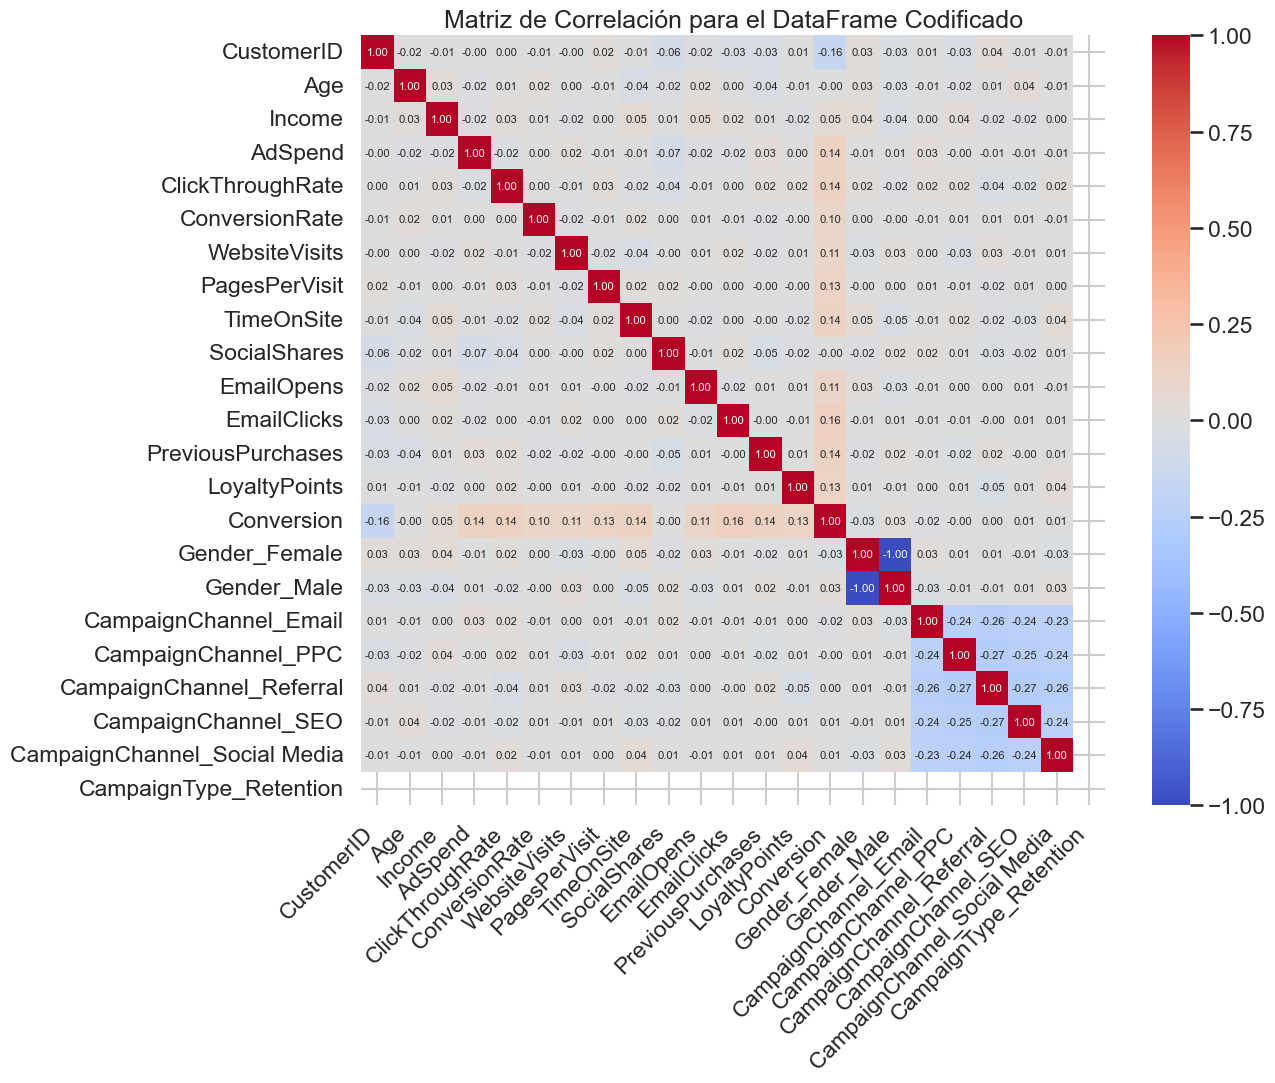

In [21]:
# Calcular la matriz de correlación
correlation_matrix = df_encoded.corr()

# Visualizar la matriz de correlación con números
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    annot_kws={"size": 8}
)

# Rotar las etiquetas del eje X 45 grados
plt.xticks(rotation=45, ha='right')  # ha='right' para alinearlas a la derecha
plt.title('Matriz de Correlación para el DataFrame Codificado')
plt.show()

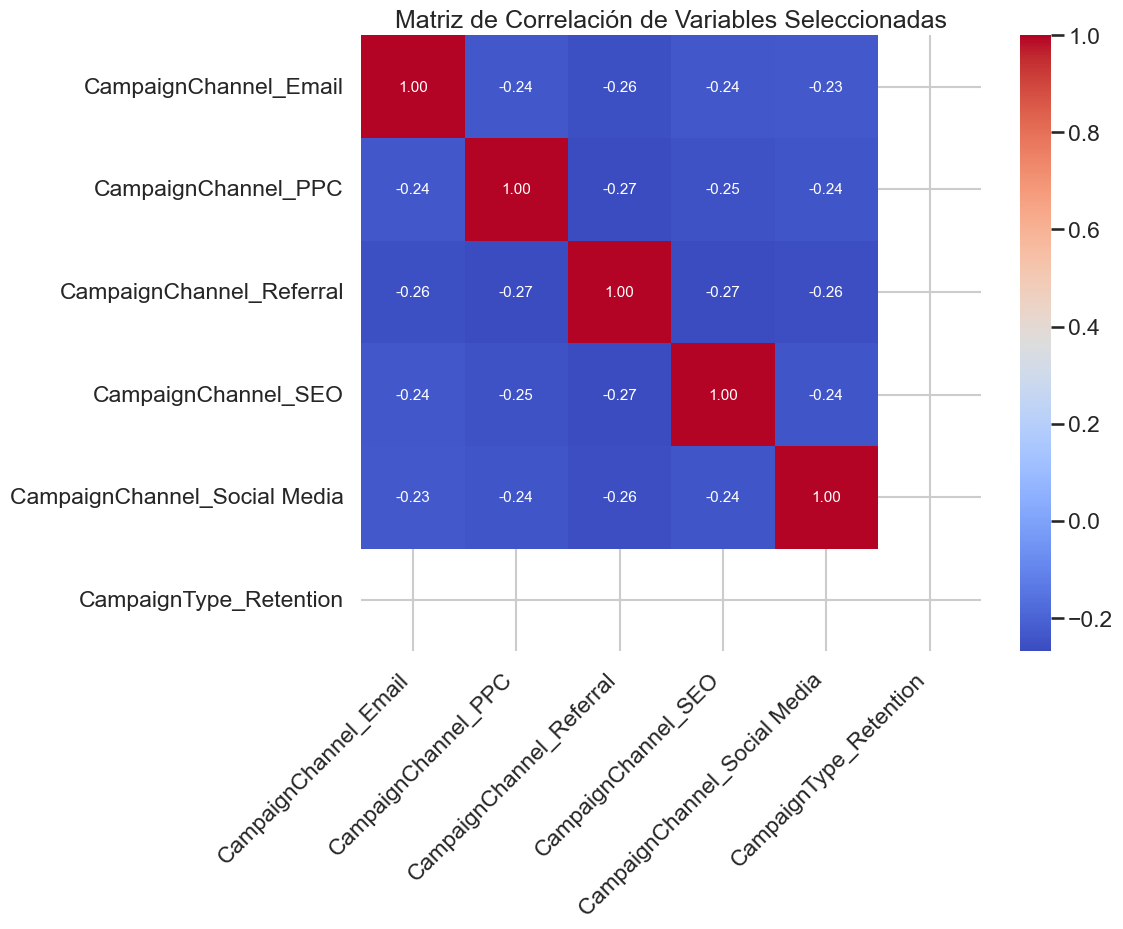

In [22]:
# Seleccionar las columnas específicas
selected_columns = [
    'CampaignChannel_Email', 'CampaignChannel_PPC', 'CampaignChannel_Referral',
    'CampaignChannel_SEO', 'CampaignChannel_Social Media',
    'CampaignType_Retention'
]

# Filtrar el DataFrame para incluir solo estas columnas
filtered_df = df_encoded[selected_columns]

# Calcular la matriz de correlación
correlation_matrix = filtered_df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f', 
    annot_kws={"size": 11}
)

# Rotar las etiquetas del eje X 45 grados
plt.xticks(rotation=45, ha='right')  # Girar etiquetas y alinearlas a la derecha
plt.title('Matriz de Correlación de Variables Seleccionadas')
plt.show()

C:\Users\mikel\AppData\Local\Temp\ipykernel_27492\1322211850.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Conversion'] = df_encoded['Conversion']  # Añadir la variable objetivo


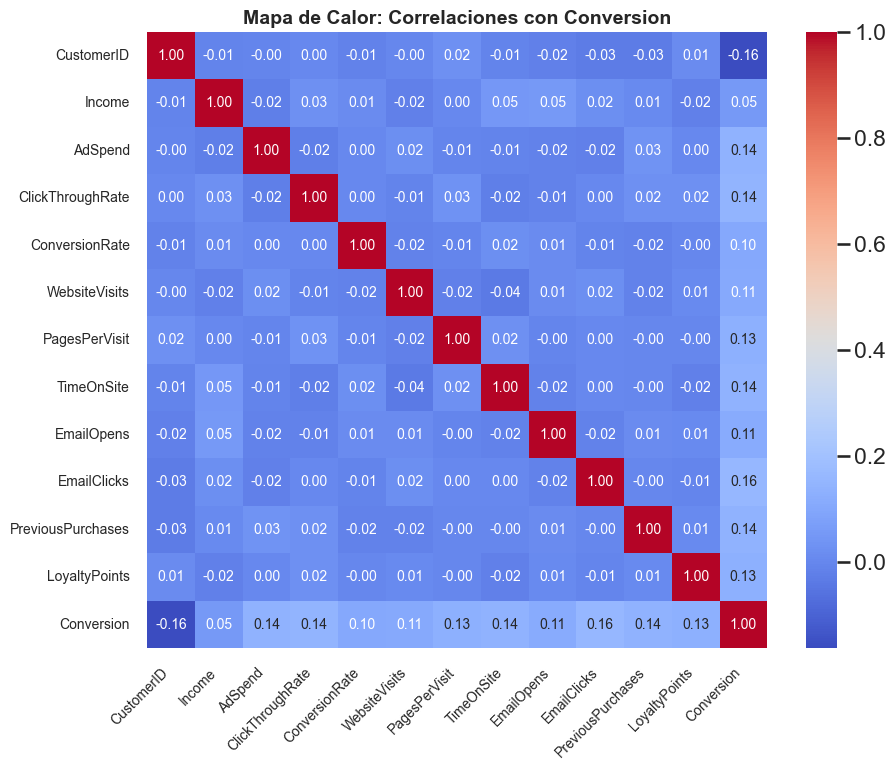

In [23]:
# Calcular la matriz de correlación
correlation_matrix = df_encoded.corr()

# Seleccionar las correlaciones con la variable objetivo 'Conversion'
correlations_with_target = correlation_matrix['Conversion'].drop('Conversion')

# Filtrar las variables con correlación
selected_features = correlations_with_target[abs(correlations_with_target) > 0.05].index

# Crear un DataFrame con las variables seleccionadas
df_filtered = df_encoded[selected_features]
df_filtered['Conversion'] = df_encoded['Conversion']  # Añadir la variable objetivo

# Crear el mapa de calor
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(
    df_filtered.corr(),
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10},  # Reducir el tamaño de los números
    cmap="coolwarm",
    cbar=True
)

# Ajustar las etiquetas del eje X
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.title("Mapa de Calor: Correlaciones con Conversion", fontsize=14, fontweight="bold")
plt.show()

c:\Users\mikel\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [15:30:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


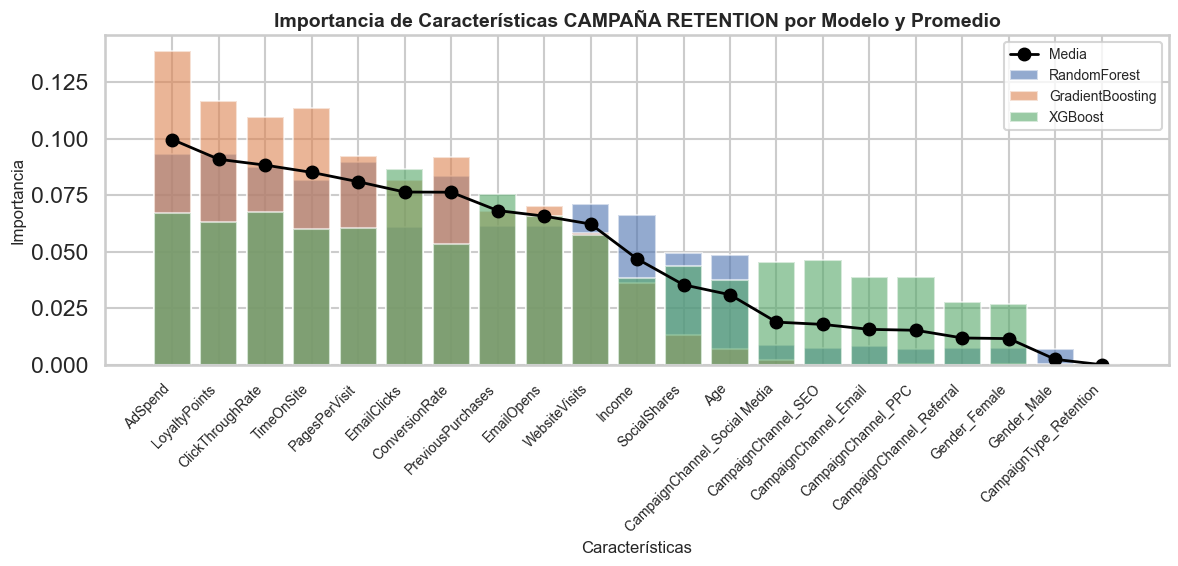

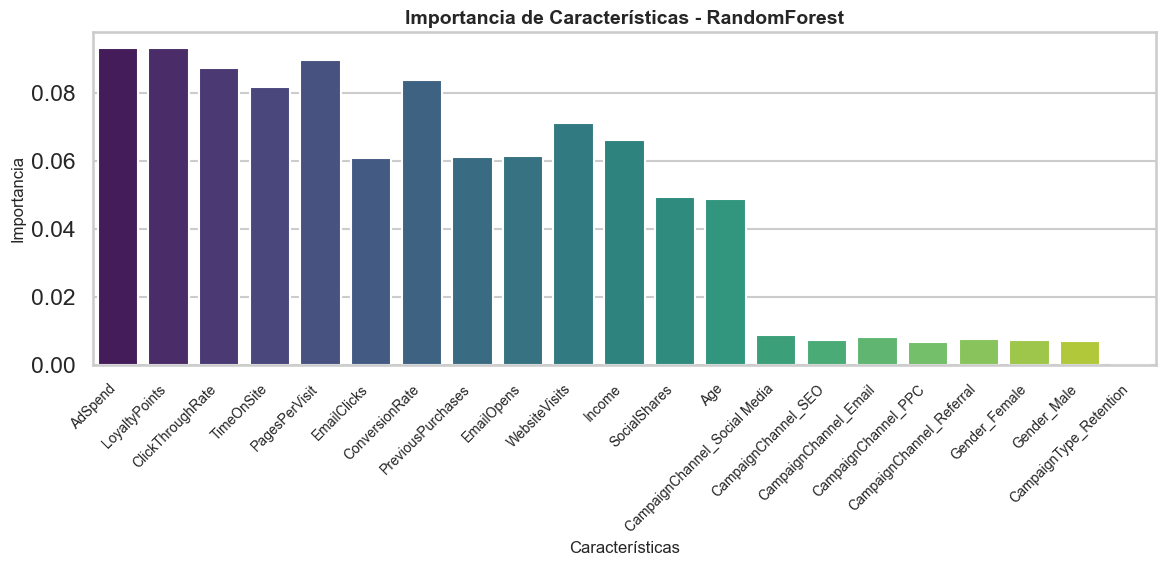

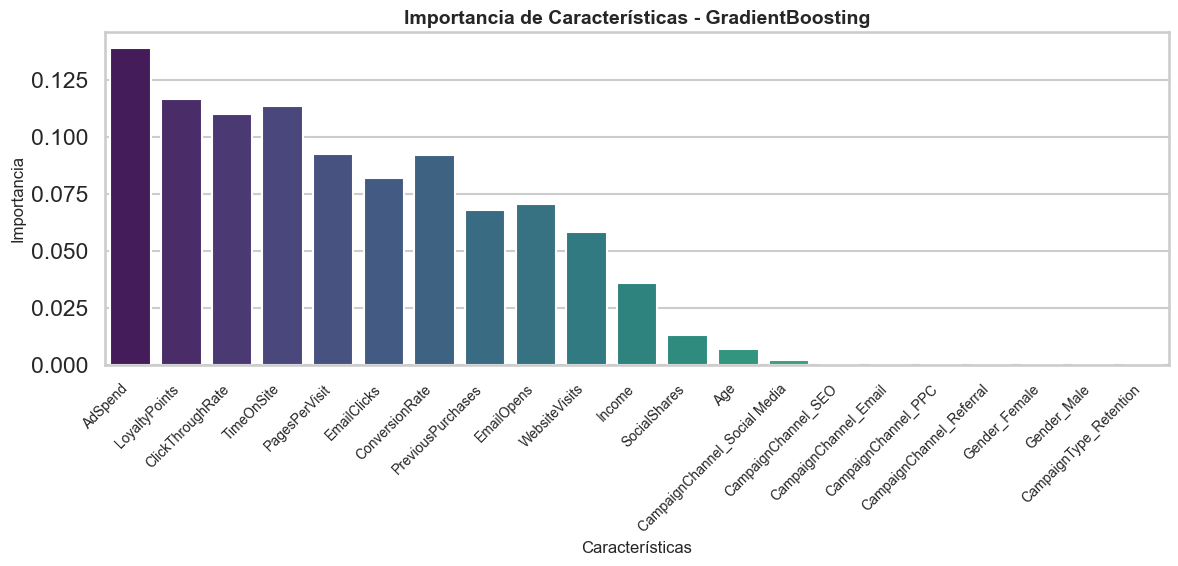

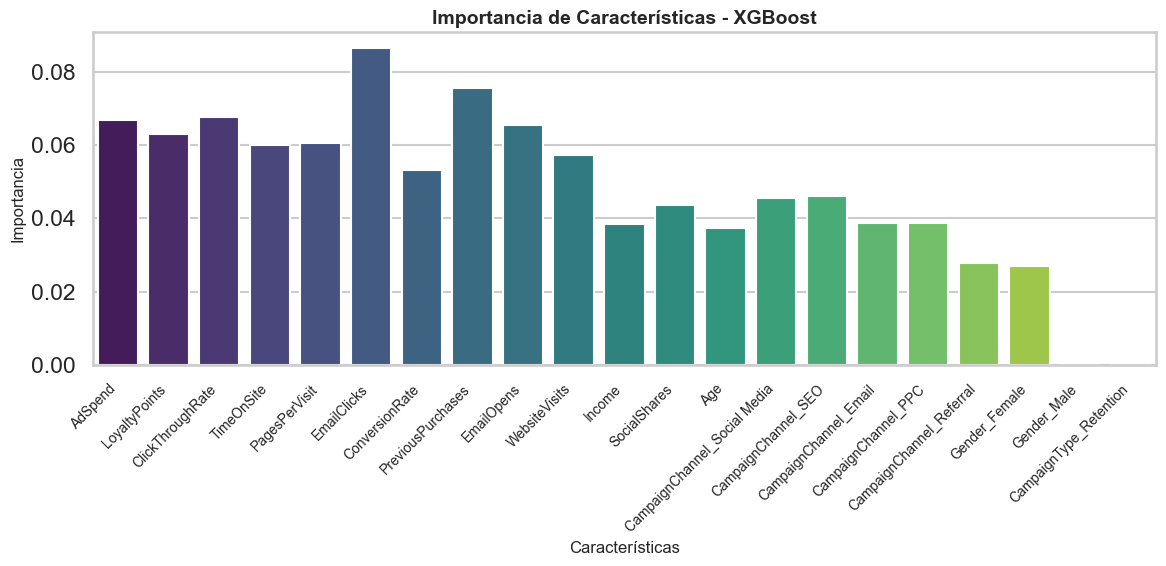

Tabla de Importancias:
                              RandomForest  GradientBoosting   XGBoost  \
AdSpend                           0.093156          0.138752  0.066902   
LoyaltyPoints                     0.093089          0.116508  0.062994   
ClickThroughRate                  0.087409          0.109788  0.067650   
TimeOnSite                        0.081688          0.113497  0.060032   
PagesPerVisit                     0.089806          0.092415  0.060580   
EmailClicks                       0.060950          0.081676  0.086499   
ConversionRate                    0.083649          0.091923  0.053322   
PreviousPurchases                 0.061146          0.067917  0.075535   
EmailOpens                        0.061310          0.070251  0.065615   
WebsiteVisits                     0.071030          0.058228  0.057436   
Income                            0.066054          0.036022  0.038389   
SocialShares                      0.049235          0.013235  0.043578   
Age            

In [24]:
# Variables predictoras y objetivo
X = df_encoded.drop(columns=['Conversion', 'CustomerID'])
y = df_encoded['Conversion']

# Modelos a usar
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Entrenar cada modelo y calcular importancia de características
importances_dict = {}
for model_name, model in models.items():
    model.fit(X, y)
    importances_dict[model_name] = model.feature_importances_

# Crear un DataFrame con las importancias
importances_df = pd.DataFrame(importances_dict, index=X.columns)

# Calcular la media de importancias
importances_df['Mean_Importance'] = importances_df.mean(axis=1)

# Ordenar por importancia media
importances_df = importances_df.sort_values(by='Mean_Importance', ascending=False)

# Gráfico combinado de importancias
plt.figure(figsize=(12, 6))

# Graficar las importancias de cada modelo
for model_name in models.keys():
    plt.bar(importances_df.index, importances_df[model_name], alpha=0.6, label=model_name)

# Graficar la media de importancias como una línea
plt.plot(importances_df['Mean_Importance'], color='black', marker='o', linestyle='-', linewidth=2, label='Media')

# Ajustar el gráfico combinado
plt.title('Importancia de Características CAMPAÑA RETENTION por Modelo y Promedio', fontsize=14, fontweight='bold')
plt.xlabel('Características', fontsize=12)
plt.ylabel('Importancia', fontsize=12)
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

# Gráficos individuales por modelo
for model_name in models.keys():
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=importances_df.index,
        y=importances_df[model_name],
        palette="viridis",
    )
    plt.title(f'Importancia de Características - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Características', fontsize=12)
    plt.ylabel('Importancia', fontsize=12)
    plt.xticks(rotation=45, fontsize=10, ha='right')
    plt.tight_layout()
    plt.show()

# Mostrar la tabla de importancias
print("Tabla de Importancias:")
print(importances_df)

In [25]:
# Seleccionar características con importancia media > umbral
threshold = 0.03
selected_features = importances_df[importances_df['Mean_Importance'] > threshold].index

# Seleccionar características con importancia media > umbral
selected_features = importances_df[importances_df['Mean_Importance'] > threshold].index

# Seleccionar características descartadas con importancia media <= umbral
discarded_features = importances_df[importances_df['Mean_Importance'] <= threshold].index

# Mostrar las características seleccionadas y descartadas
print(f"Características seleccionadas:\n{selected_features}")
print(f"\nCaracterísticas descartadas:\n{discarded_features}")

Características seleccionadas:
Index(['AdSpend', 'LoyaltyPoints', 'ClickThroughRate', 'TimeOnSite',
       'PagesPerVisit', 'EmailClicks', 'ConversionRate', 'PreviousPurchases',
       'EmailOpens', 'WebsiteVisits', 'Income', 'SocialShares', 'Age'],
      dtype='object')

Características descartadas:
Index(['CampaignChannel_Social Media', 'CampaignChannel_SEO',
       'CampaignChannel_Email', 'CampaignChannel_PPC',
       'CampaignChannel_Referral', 'Gender_Female', 'Gender_Male',
       'CampaignType_Retention'],
      dtype='object')


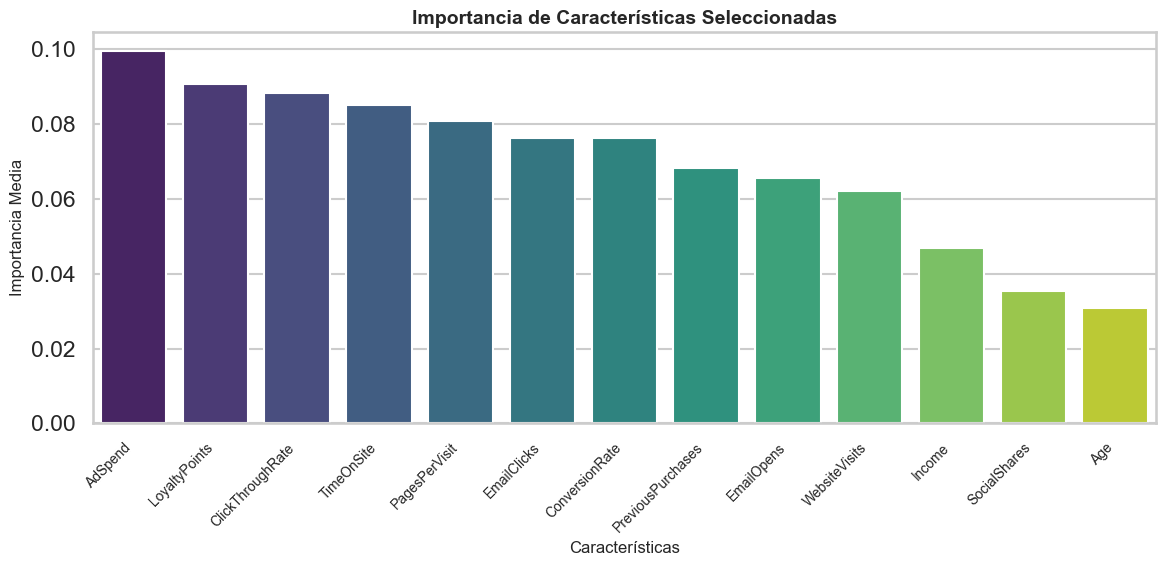

In [26]:
# Crear un DataFrame con las características seleccionadas y sus importancias
selected_features_df = importances_df.loc[selected_features]

# Graficar las características seleccionadas con sus importancias
plt.figure(figsize=(12, 6))
sns.barplot(
    x=selected_features_df.index,
    y=selected_features_df['Mean_Importance'],
    palette="viridis",
)

# Ajustes del gráfico
plt.title("Importancia de Características Seleccionadas", fontsize=14, fontweight="bold")
plt.xlabel("Características", fontsize=12)
plt.ylabel("Importancia Media", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()

# **PREDICTOR DE CONVERSIÓN**

In [27]:
# Variables predictoras y objetivo
X = df_encoded.drop(columns=['Conversion', 'CustomerID'])
y = df_encoded['Conversion']

# Configuración para mostrar todo el texto en DataFrames
pd.set_option('display.max_colwidth', None)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Aplicar SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train, y_train)

# Modelos y parámetros
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier( random_state=42),
}

param_grids = {
    "RandomForest": {
        "classifier__n_estimators": [60, 80],
        "classifier__max_depth": [12, 14],
        "classifier__min_samples_split": [10, 12],
        "classifier__min_samples_leaf": [5, 6],
    },
    "GradientBoosting": {
        "classifier__n_estimators": [200, 250],
        "classifier__learning_rate": [0.05, 0.06],
        "classifier__max_depth": [3, 4],
        "classifier__subsample": [0.6, 0.7],
    },
    "XGBoost": {
        "classifier__n_estimators": [100, 125],
        "classifier__learning_rate": [0.06, 0.08],
        "classifier__max_depth": [4],
        "classifier__gamma": [0.5, 0.7],
        "classifier__reg_alpha": [1, 5],
        "classifier__reg_lambda": [5, 10],
        "classifier__subsample": [0.6, 0.7],
    },
}

# Almacenar resultados
all_results = []

# Crear pipelines y ajustar modelos
for model_name, model in models.items():
    pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),  # Escalado
            ("classifier", model),  # Modelo
        ]
    )

    param_grid = param_grids[model_name]

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring="recall",
        cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
        n_jobs=-1,
    )

    grid_search.fit(X_train_balanced, y_train_balanced)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_  # Obtener mejores parámetros
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Resultados
    recall_train = recall_score(y_train_balanced, best_model.predict(X_train_balanced))
    recall_test = recall_score(y_test, y_pred)
    precision_test = precision_score(y_test, y_pred)
    f1_test = f1_score(y_test, y_pred)
    roc_auc_test = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)

    # Guardar modelo
    joblib.dump(best_model, f"{model_name}_best_model.pkl")

    # Guardar resultados
    all_results.append(
        {
            "Model": model_name,
            "Best Params": best_params,
            "Recall (Train)": recall_train,
            "Recall (Test)": recall_test,
            "Precision (Test)": precision_test,
            "F1-Score (Test)": f1_test,
            "ROC-AUC (Test)": roc_auc_test,
            "Confusion Matrix": cm,
        }
    )

# Mostrar resultados
df_results = pd.DataFrame(all_results)
print("\nResultados finales:")
print(df_results)

# Mostrar matrices de confusión
for result in all_results:
    print(f"\nMatriz de Confusión para {result['Model']}:")
    print(result['Confusion Matrix'])


Resultados finales:
              Model  \
0      RandomForest   
1  GradientBoosting   
2           XGBoost   

                                                                                                                                                                                                         Best Params  \
0                                                                              {'classifier__max_depth': 12, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 60}   
1                                                                                     {'classifier__learning_rate': 0.05, 'classifier__max_depth': 4, 'classifier__n_estimators': 250, 'classifier__subsample': 0.6}   
2  {'classifier__gamma': 0.5, 'classifier__learning_rate': 0.06, 'classifier__max_depth': 4, 'classifier__n_estimators': 125, 'classifier__reg_alpha': 1, 'classifier__reg_lambda': 5, 'classifier__subsample': 0.7}   

   Recall (Train)  Re

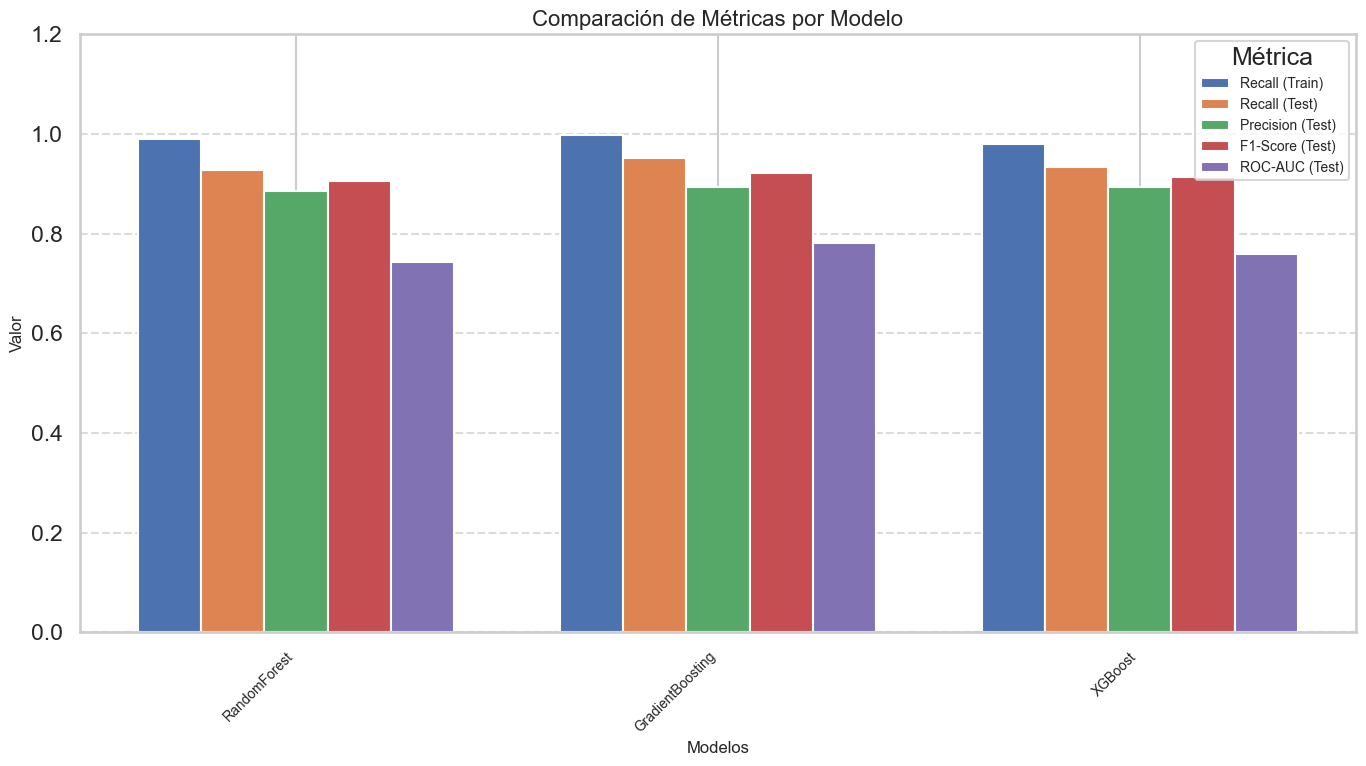

In [28]:
# --- Métricas y modelos ---
metrics = [
    "Recall (Train)", "Recall (Test)", 
    "Precision (Test)", "F1-Score (Test)", "ROC-AUC (Test)"
]
models = df_results["Model"]

# --- Datos ---
values = [df_results[metric].values for metric in metrics]
x = np.arange(len(models))  # Posiciones en X para los modelos
width = 0.15  # Ancho de cada barra

# --- Gráfico de barras ---
plt.figure(figsize=(14, 8))

# Añadir las barras para cada métrica
for i, (metric, metric_values) in enumerate(zip(metrics, values)):
    plt.bar(
        x + i * width,  # Desplazar barras
        metric_values,
        width=width,
        label=metric
    )

# Configuración del gráfico
plt.title("Comparación de Métricas por Modelo", fontsize=16)
plt.xlabel("Modelos", fontsize=12)
plt.ylabel("Valor", fontsize=12)
plt.xticks(x + (len(metrics) - 1) * width / 2, models, rotation=45, ha="right", fontsize=10)
plt.ylim(0, 1.2)  # Ajustar límites del eje Y
plt.legend(title="Métrica", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

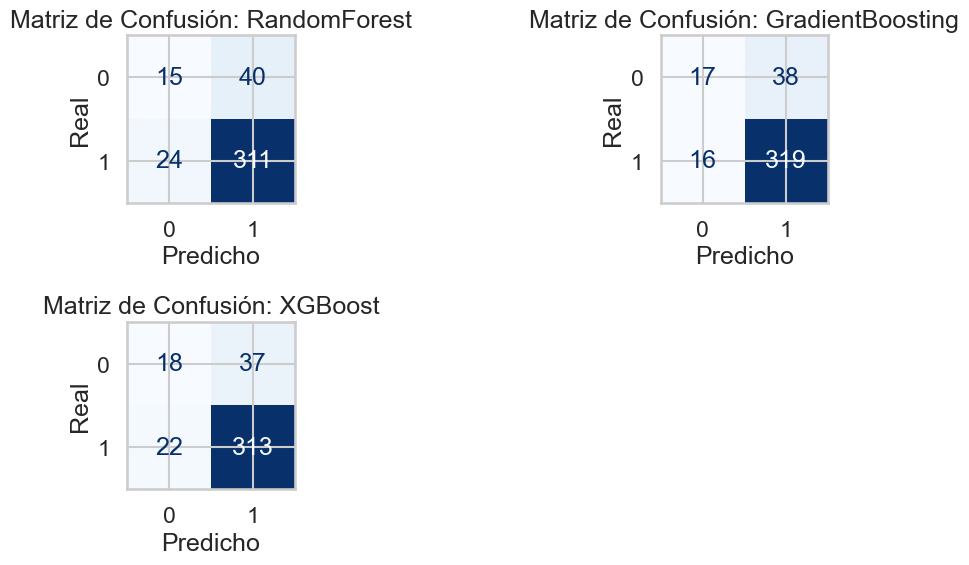

In [29]:
# --- Configuración de las matrices de confusión ---
fig, axes = plt.subplots(nrows=(len(all_results) + 1) // 2, ncols=2, figsize=(12, len(all_results) * 2))

for i, result in enumerate(all_results):
    model_name = result["Model"]
    cm = result["Confusion Matrix"]
    ax = axes[i // 2, i % 2]  # Elegir la posición de la matriz de confusión

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=False)

    ax.set_title(f"Matriz de Confusión: {model_name}")
    ax.set_xlabel("Predicho")  # Dejar vacío el eje X
    ax.set_ylabel("Real")  # Dejar vacío el eje Y

# Eliminar ejes vacíos si no hay un número par de modelos
if len(all_results) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

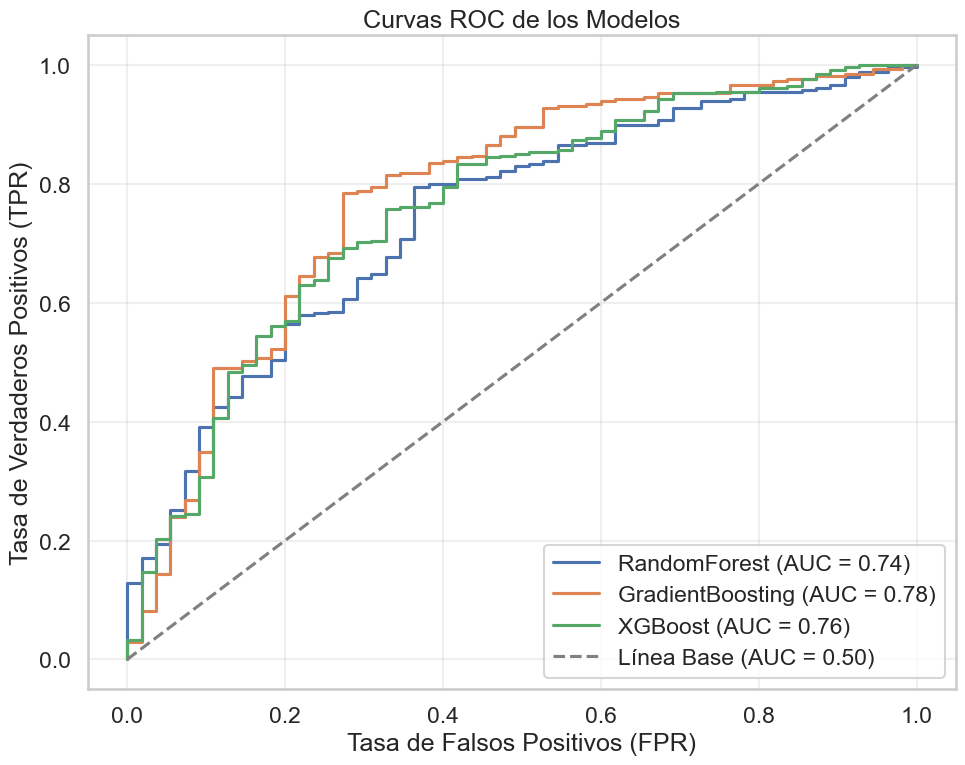

In [30]:
# --- Configuración para las curvas ROC ---
plt.figure(figsize=(10, 8))

for result in all_results:
    model_name = result["Model"]

    # Cargar el modelo desde el archivo
    model = joblib.load(f"{model_name}_best_model.pkl") if model_name != "StackingClassifier" else joblib.load("StackingClassifier_best_model.pkl")

    # Predecir probabilidades en el conjunto de prueba
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calcular FPR y TPR
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Graficar la curva ROC
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Configuración del gráfico
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Línea Base (AUC = 0.50)")  # Línea base
plt.title("Curvas ROC de los Modelos")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [31]:
# Número de registros originales en el conjunto de entrenamiento
original_train_size = len(X_train)

# Número de registros después de aplicar SMOTE + Tomek Links
balanced_train_size = len(X_train_balanced)

# Mostrar resultados
print(f"Registros originales en el conjunto de entrenamiento: {original_train_size}")
print(f"Registros después de SMOTE + Tomek Links (balanceados): {balanced_train_size}")
print(f"Registros totales utilizados en el entrenamiento: {balanced_train_size}")

Registros originales en el conjunto de entrenamiento: 1557
Registros después de SMOTE + Tomek Links (balanceados): 2490
Registros totales utilizados en el entrenamiento: 2490


In [32]:
print(y.value_counts(normalize=True))
print(y_train_balanced.value_counts(normalize=True))

Conversion
1    0.858243
0    0.141757
Name: proportion, dtype: float64
Conversion
1    0.5
0    0.5
Name: proportion, dtype: float64


In [33]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print(y_pred_proba[:10])

[0.9279371  0.85240996 0.9302516  0.44230872 0.9636798  0.9229167
 0.53443694 0.5745472  0.3705404  0.82600707]


In [34]:
print(np.isnan(y_test).sum(), np.isnan(y_pred_proba).sum())
print(np.isinf(y_pred_proba).sum())

0 0
0


In [35]:
print(y_test.unique())

[1 0]


# **SEGMENTACIÓN DE CLIENTES CON KMEANS**

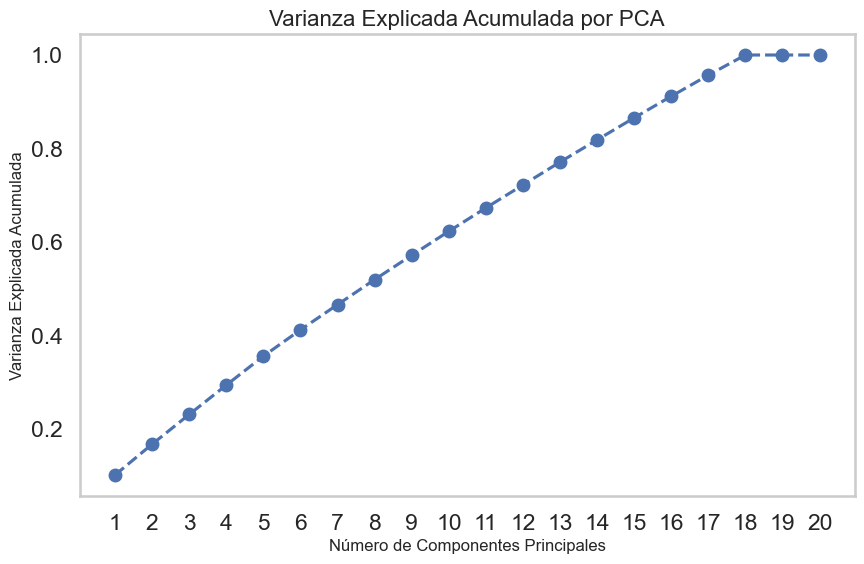


Cargas de las variables en cada componente principal:
               Age  Gender_Male  Gender_Female        Income  \
PC1  -3.976375e-02     0.699177      -0.699177 -6.897119e-02   
PC2   8.482955e-02    -0.013862       0.013862 -1.271465e-01   
PC3   1.681064e-01    -0.016082       0.016082 -7.556232e-02   
PC4   4.727980e-02     0.028382      -0.028382  9.272653e-02   
PC5  -4.469726e-02     0.036363      -0.036363 -4.965444e-02   
PC6   1.149494e-01     0.015039      -0.015039  1.940877e-01   
PC7   5.075253e-01     0.053298      -0.053298  4.252293e-01   
PC8  -1.738405e-01     0.043768      -0.043768  3.103712e-01   
PC9  -4.604397e-02    -0.019860       0.019860 -1.671961e-01   
PC10 -2.504333e-01    -0.005471       0.005471  3.406242e-01   
PC11  2.791149e-01     0.003623      -0.003623  9.343338e-02   
PC12 -1.920447e-01     0.002450      -0.002450 -1.226427e-02   
PC13  2.497150e-01    -0.003687       0.003687  2.566849e-02   
PC14  2.507847e-01     0.050633      -0.050633  1

In [36]:
# Filtrar las columnas relevantes
variables_cluster = ["Age", "Gender_Male", "Gender_Female","Income", "ClickThroughRate", "ConversionRate", "WebsiteVisits", "PagesPerVisit", "TimeOnSite", "SocialShares", "EmailOpens", "EmailClicks", "PreviousPurchases","LoyaltyPoints","AdSpend",'CampaignChannel_Social Media', 'CampaignChannel_Email',
       'CampaignChannel_PPC', 'CampaignChannel_Referral','CampaignChannel_SEO']
data_pca = df_encoded[variables_cluster]

# Escalar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_pca)

# Aplicar PCA
pca = PCA(n_components=len(variables_cluster))  # Crear tantos componentes como variables
pca.fit(data_scaled)

# Varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Gráfico de la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(variables_cluster) + 1), np.cumsum(explained_variance), marker='o', linestyle='--', color='b')
plt.title('Varianza Explicada Acumulada por PCA', fontsize=16)
plt.xlabel('Número de Componentes Principales', fontsize=12)
plt.ylabel('Varianza Explicada Acumulada', fontsize=12)
plt.xticks(range(1, len(variables_cluster) + 1))
plt.grid()
plt.show()

# Mostrar los pesos (cargas) de cada variable en los componentes principales
pca_components = pd.DataFrame(pca.components_, columns=variables_cluster, index=[f'PC{i+1}' for i in range(len(variables_cluster))])

print("\nCargas de las variables en cada componente principal:")
print(pca_components)

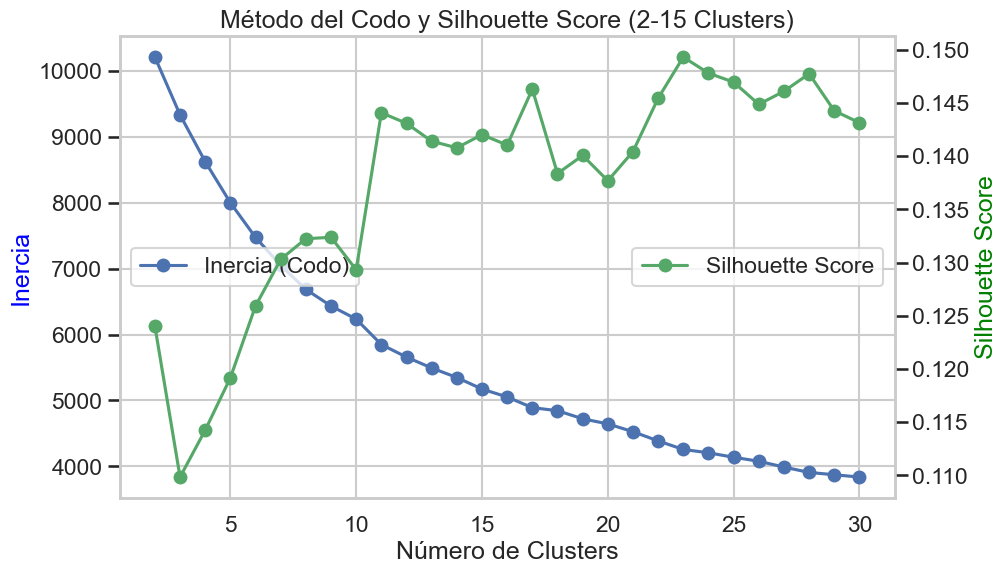

C:\Users\mikel\AppData\Local\Temp\ipykernel_27492\1470002341.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cluster["Cluster"] = kmeans.fit_predict(data_scaled)


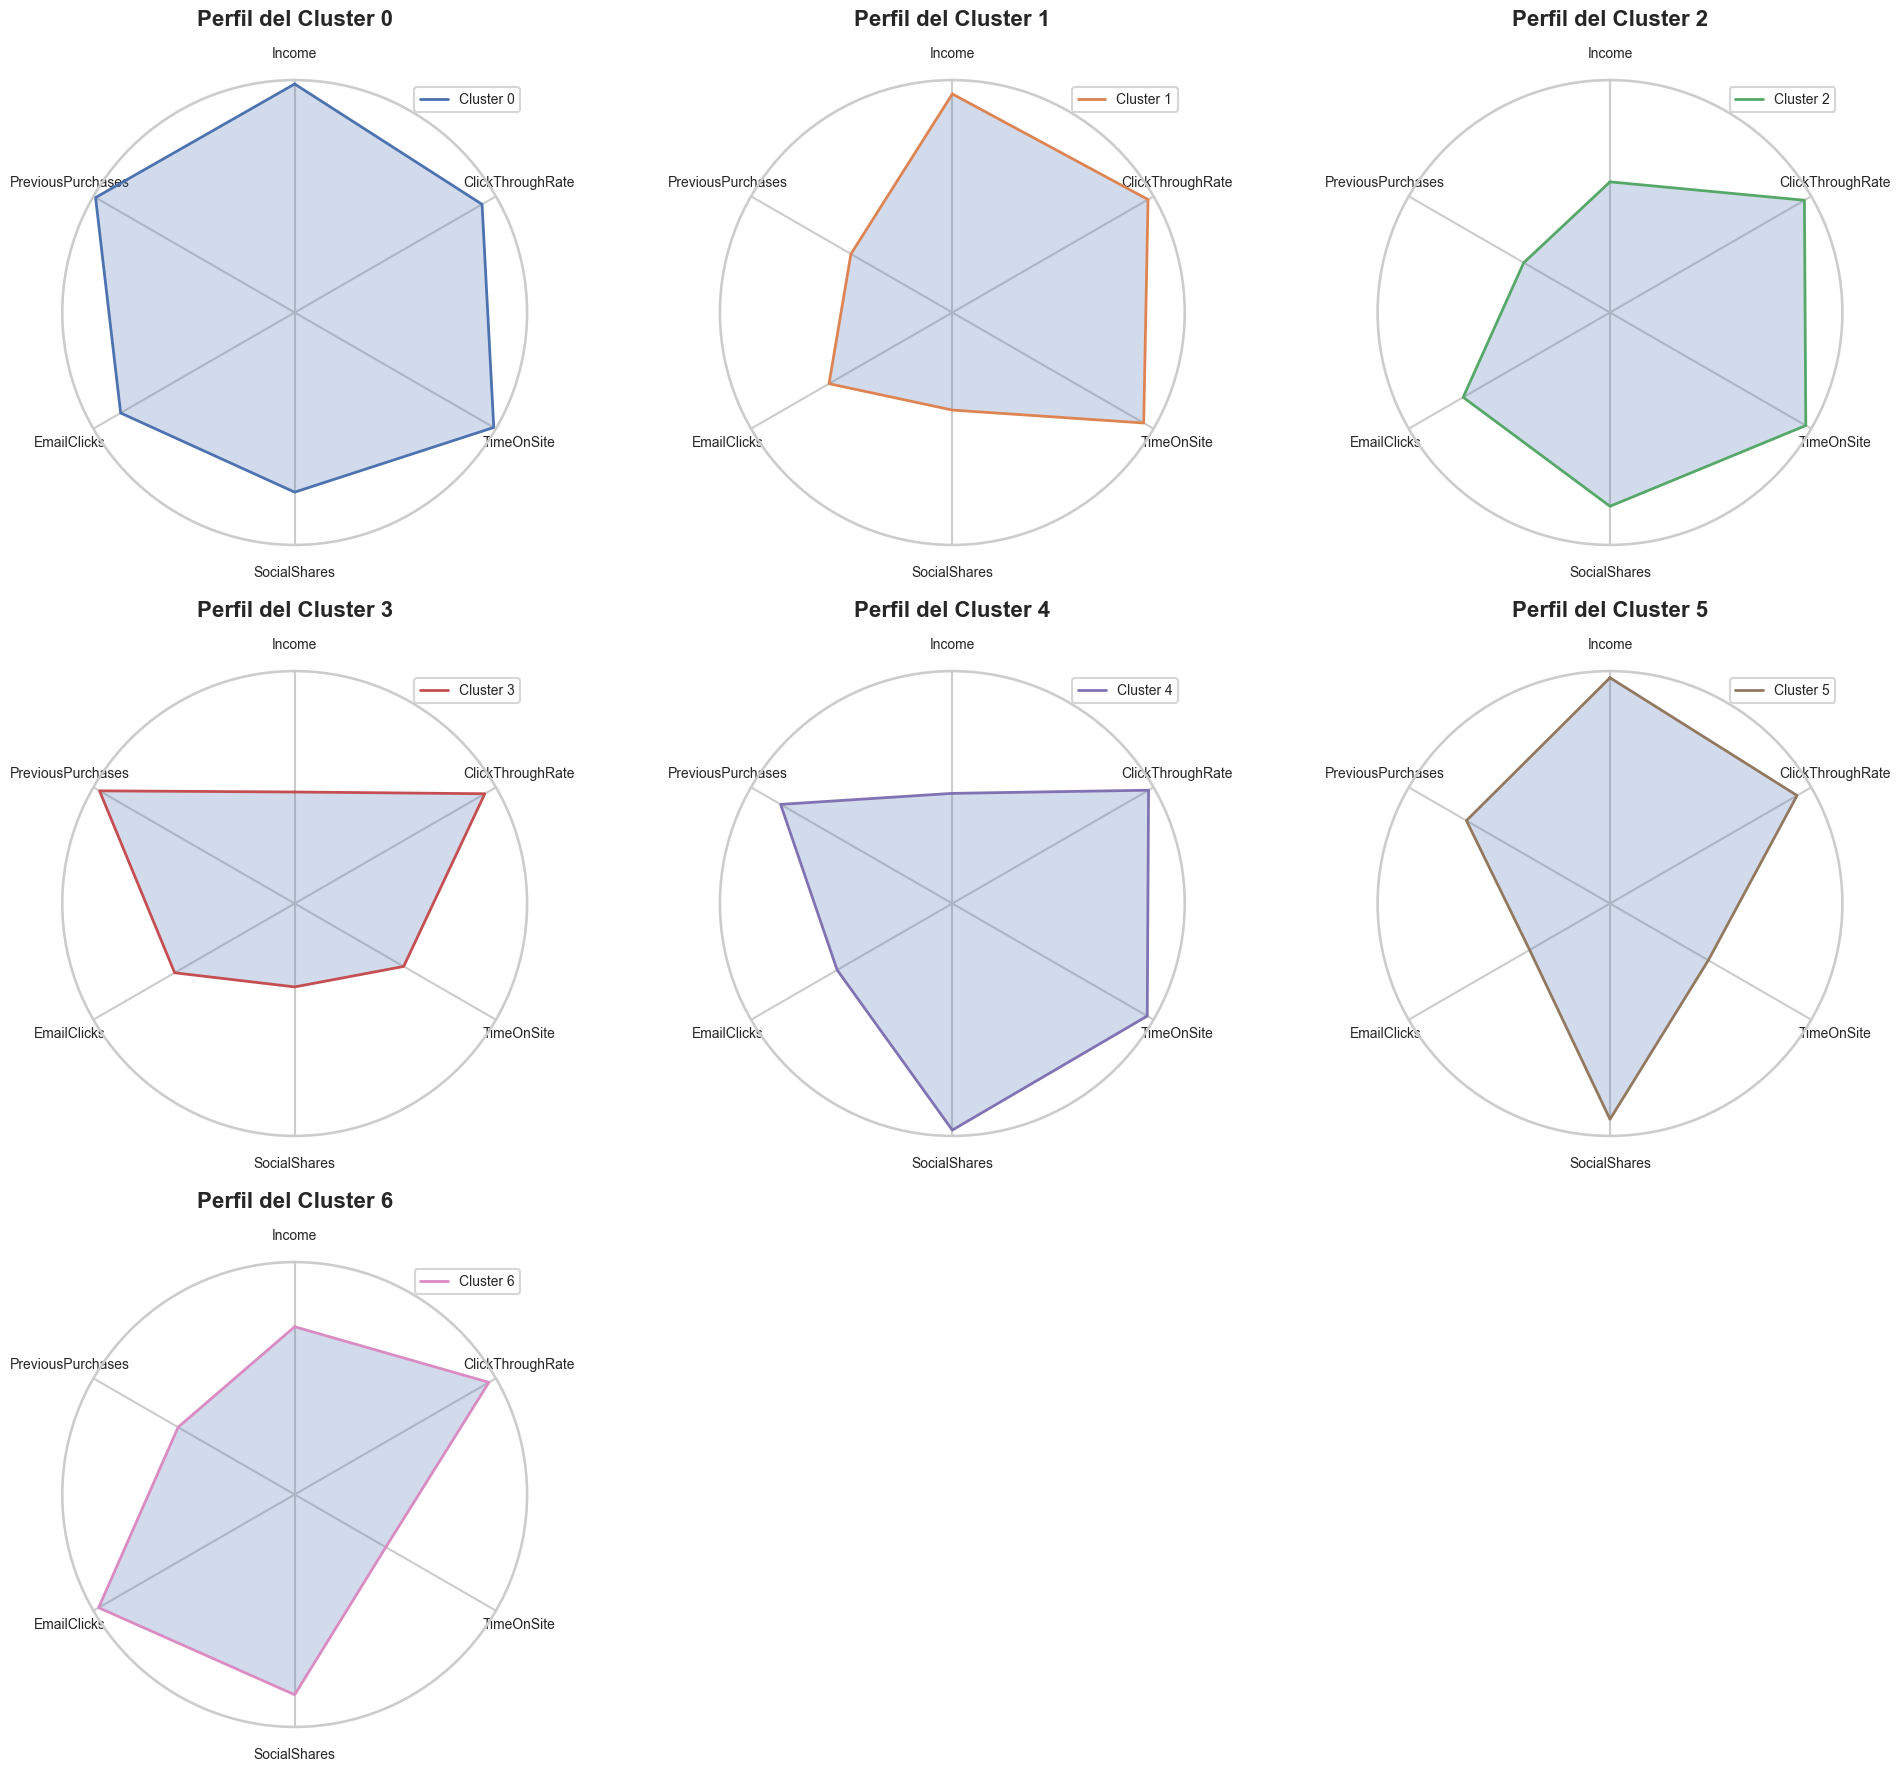

In [37]:
# Filtrar las columnas relevantes
variables_cluster = ["Income", "ClickThroughRate", "TimeOnSite", "SocialShares", "EmailClicks", "PreviousPurchases"]
data_cluster = df_encoded[variables_cluster]

# Escalar las variables
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cluster)

# Determinar el número óptimo de clusters con el método del codo y silhouette score
inertia = []
silhouette_scores = []
max_clusters = 30

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))

# Gráfico combinado: Método del Codo y Silhouette Score
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot(range(2, max_clusters + 1), inertia, 'o-b', label='Inercia (Codo)')
ax2.plot(range(2, max_clusters + 1), silhouette_scores, 'o-g', label='Silhouette Score')

ax1.set_xlabel("Número de Clusters")
ax1.set_ylabel("Inercia", color="blue")
ax2.set_ylabel("Silhouette Score", color="green")
plt.title("Método del Codo y Silhouette Score (2-15 Clusters)")
ax1.legend(loc="center left")
ax2.legend(loc="center right")
plt.grid()
plt.show()

# Elegir el número óptimo de clusters (por ejemplo, 5)
optimal_k = 7
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data_cluster["Cluster"] = kmeans.fit_predict(data_scaled)

# Crear promedios por cluster
cluster_means_scaled = data_cluster.groupby("Cluster").mean()

# Excluir la columna de 'Cluster' antes de desescalar
cluster_means_scaled = cluster_means_scaled[variables_cluster]

# Desescalar los promedios
cluster_means = pd.DataFrame(
    scaler.inverse_transform(cluster_means_scaled),
    columns=variables_cluster,
    index=cluster_means_scaled.index
)

# Normalizar los valores promedio desescalados
cluster_means_normalized = cluster_means / cluster_means.max()

# Configuración para Spider Plot en filas de 3
categories = cluster_means.columns
num_vars = len(categories)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Cerrar el círculo

# Configuración del número de filas y columnas
cols = 3  # Máximo de gráficos por fila
rows = (optimal_k + cols - 1) // cols  # Calcular filas necesarias
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 6), subplot_kw=dict(polar=True))

# Asegurarse de que los ejes sean unidimensionales para iterar
axes = axes.flatten()

for cluster in range(optimal_k):
    # Seleccionar el eje correspondiente
    ax = axes[cluster]

    # Valores del cluster actual
    values = cluster_means_normalized.iloc[cluster].values.flatten().tolist()
    values += values[:1]  # Cerrar el círculo

    # Añadir datos del cluster
    ax.plot(angles, values, label=f"Cluster {cluster}", linewidth=2, color=f"C{cluster}")
    ax.fill(angles, values, alpha=0.25)

    # Configuración del gráfico
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_yticks([])
    ax.set_title(f"Perfil del Cluster {cluster}", size=16, fontweight="bold", y=1.1)

    # Leyenda
    ax.legend(loc="upper right", fontsize=10)

# Eliminar ejes vacíos si los clusters no llenan la última fila
for i in range(optimal_k, len(axes)):
    fig.delaxes(axes[i])

# Ajustar el espaciado para evitar solapamientos
plt.tight_layout()
plt.show()

In [38]:
data_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1947 entries, 1 to 7996
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Income             1947 non-null   int64  
 1   ClickThroughRate   1947 non-null   float64
 2   TimeOnSite         1947 non-null   float64
 3   SocialShares       1947 non-null   int64  
 4   EmailClicks        1947 non-null   int64  
 5   PreviousPurchases  1947 non-null   int64  
 6   Cluster            1947 non-null   int32  
dtypes: float64(2), int32(1), int64(4)
memory usage: 114.1 KB


In [39]:
# Asegurarnos de que CustomerID esté en data_cluster
data_cluster["CustomerID"] = df_encoded["CustomerID"]

# Validar la asignación: comparar algunas filas de data_cluster con df_encoded
print("Validando asignación de CustomerID...")
print("Primeras filas de data_cluster:")
print(data_cluster.head())

print("\nPrimeras filas relevantes de df_encoded:")
print(df_encoded[["CustomerID", "Income", "ClickThroughRate"]].head())

# Comprobar si CustomerID está correctamente alineado
valid = all(data_cluster["Income"] == df_encoded["Income"])
if valid:
    print("\n✔️ La asignación de CustomerID es correcta y los datos están alineados.")
else:
    print("\n❌ Hay discrepancias en los datos. Revisa el orden de las filas o el origen de data_cluster.")

Validando asignación de CustomerID...
Primeras filas de data_cluster:
    Income  ClickThroughRate  TimeOnSite  SocialShares  EmailClicks  \
1    41760          0.155725    5.352549             5            7   
8   140788          0.023536   14.287421            73            8   
10   88319          0.269148    3.294720            94            5   
27   98311          0.010644    9.332746            98            6   
28   27549          0.154715   10.672945            92            1   

    PreviousPurchases  Cluster  CustomerID  
1                   2        3        8001  
8                   5        0        8008  
10                  6        6        8010  
27                  1        2        8027  
28                  3        4        8028  

Primeras filas relevantes de df_encoded:
    CustomerID  Income  ClickThroughRate
1         8001   41760          0.155725
8         8008  140788          0.023536
10        8010   88319          0.269148
27        8027   98311     

C:\Users\mikel\AppData\Local\Temp\ipykernel_27492\4291511284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cluster["CustomerID"] = df_encoded["CustomerID"]
